In [1]:
import pandas as pd
df = pd.read_csv("df_combine.csv")

# <h1>EDA-ACF 以及 PACF</h1>

In [6]:
from statsmodels.graphics.tsaplots import plot_acf ,plot_pacf
import matplotlib.pyplot as plt

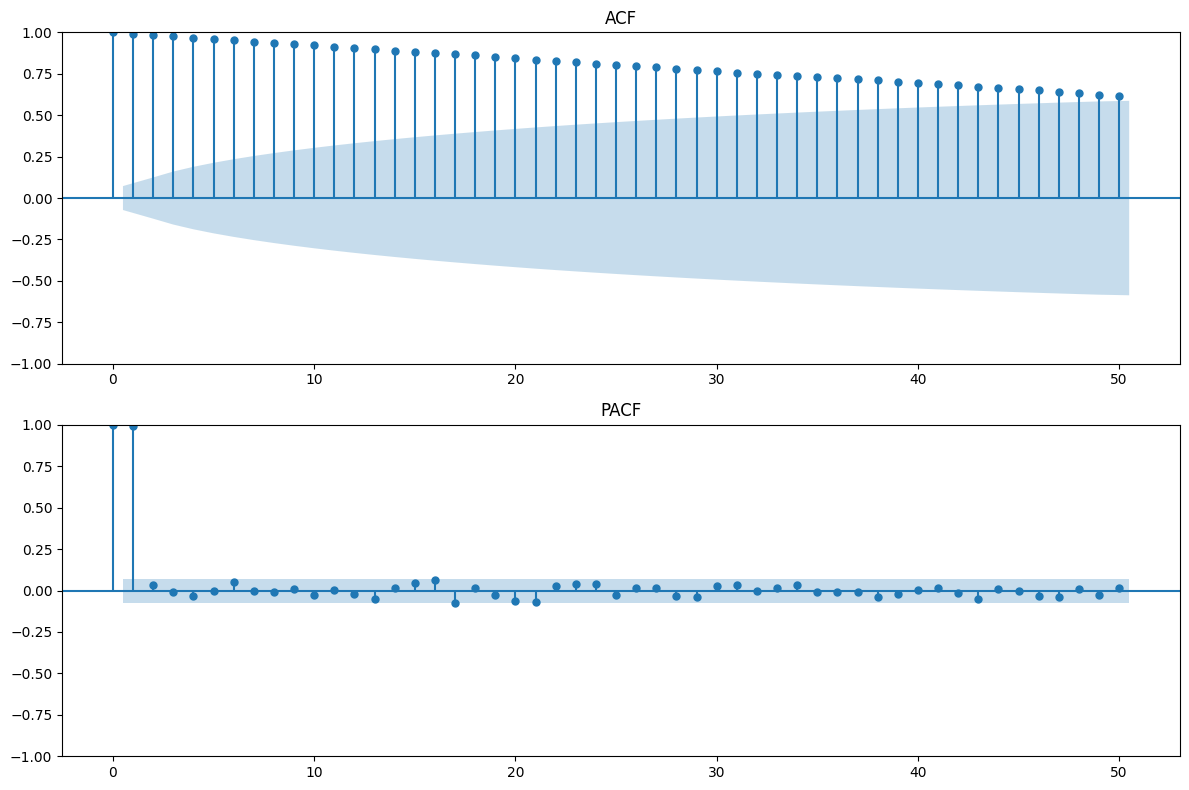

In [13]:
#計算ACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['close'], lags=50, ax=axes[0], title='ACF')
#計算PACF
plot_pacf(df['close'], lags=50, ax=axes[1], title='PACF')
plt.tight_layout()
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller
# 檢查原始數列是否平穩
result = adfuller(df['close'])
print('ADF 檢定 p-value:', result[1])
##檢定結果pvalue>=0.05   且ACF下降很慢   表示此數列為非平穩數列  有季節性跟趨勢性

ADF 檢定 p-value: 0.5625027681389074


## 差分並再進行一次檢查

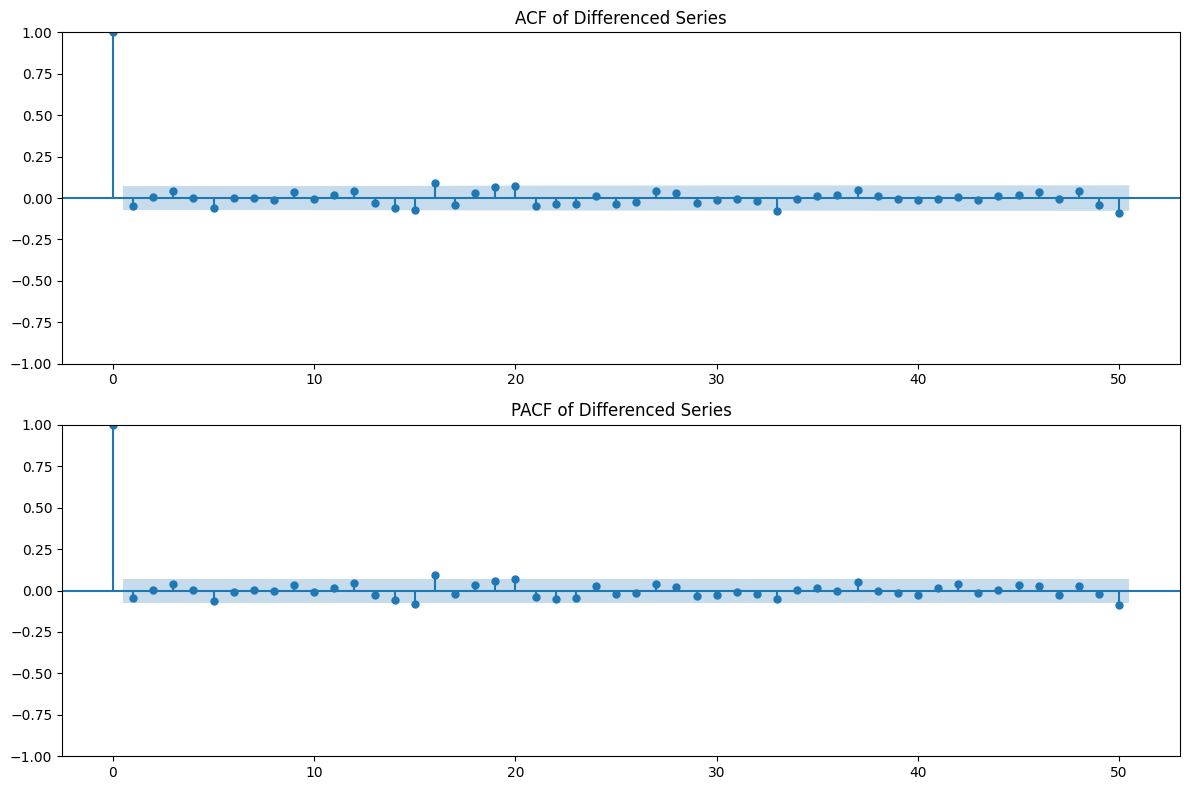

ADF Statistic (Differenced): -28.39910787728141
ADF 檢定 p-value: 0.0


In [15]:
y_diff = df["close"].diff().dropna()

# 繪製差分後數列的 ACF 和 PACF 圖
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(y_diff, lags=50, ax=axes[0], title='ACF of Differenced Series')
plot_pacf(y_diff, lags=50, ax=axes[1], title='PACF of Differenced Series')
plt.tight_layout()
plt.show()

# 再次檢查差分後數列是否平穩
result_diff = adfuller(y_diff)
print('ADF Statistic (Differenced):', result_diff[0])
print('ADF 檢定 p-value:', result_diff[1])

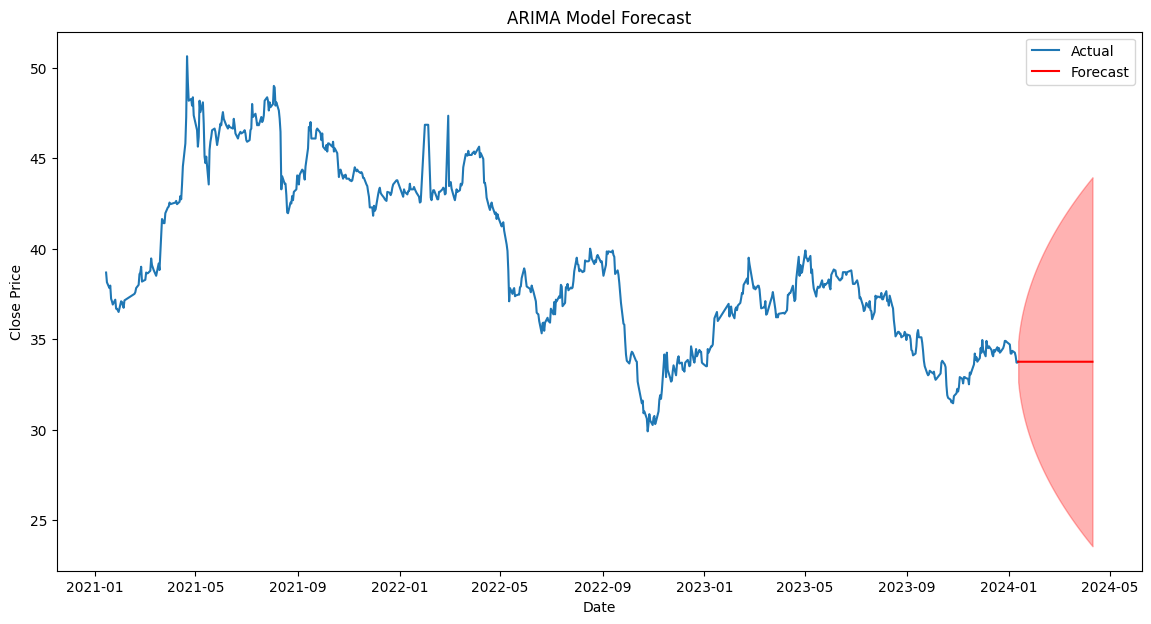

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  736
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -633.977
Date:                Sun, 16 Jun 2024   AIC                           1273.954
Time:                        23:34:50   BIC                           1287.754
Sample:                             0   HQIC                          1279.276
                                - 736                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0939      0.763     -0.123      0.902      -1.588       1.401
ma.L1          0.0462      0.760      0.061      0.951      -1.443       1.536
sigma2         0.3286      0.006     58.379      0.0

In [72]:
from statsmodels.tsa.arima.model import ARIMA
df = pd.read_csv("df_combine.csv", parse_dates=['date'])
y = df['close']
# 訓練 ARIMA 模型  
p = 1
d = 1
q = 1
model = ARIMA(y, order=(p, d, q))
results = model.fit()

# 預測
forecast_steps = 90  # 設置預測天數
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()


# 可視化預測結果
plt.figure(figsize=(14, 7))
plt.plot(df['date'], y, label='Actual')
plt.plot(pd.date_range(start=df['date'].iloc[-1], periods=forecast_steps, freq='D'), forecast_mean, label='Forecast', color='red')
plt.fill_between(pd.date_range(start=df['date'].iloc[-1], periods=forecast_steps, freq='D'), forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.3)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Model Forecast')
plt.show()
# 顯示模型結果摘要
print(results.summary())

In [44]:
# 刪除有任何欄位遺失值的行
df_cleaned = df.dropna()
y = df_cleaned['close']

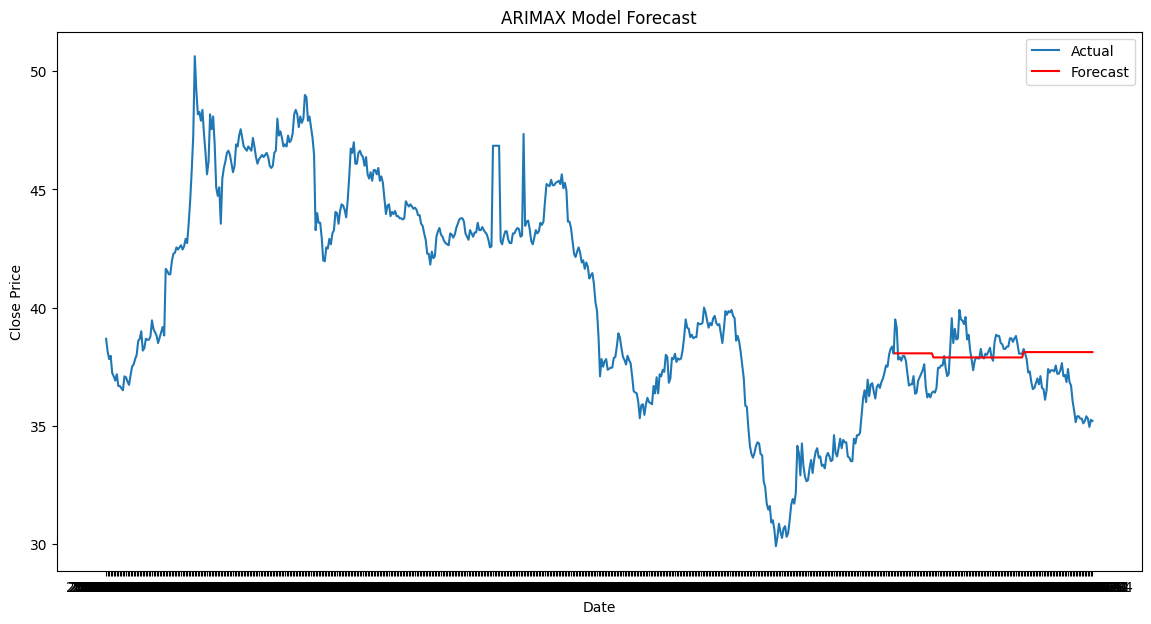

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  516
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -496.273
Date:                Sun, 16 Jun 2024   AIC                           1030.546
Time:                        22:20:43   BIC                           1111.185
Sample:                             0   HQIC                          1062.148
                                - 516                                         
Covariance Type:                  opg                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                  -2.005e-08   3.38e-08     -0.594      0.553   -8.62e-08    4.61e-08
growthNetReceivables                       0.11

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
# 選擇相關性高的變數
selected_features = ['growthNetReceivables', 'receivablesGrowth', 'fiveYNetIncomeGrowthPerShare', 'growthOtherExpenses',
                     'fiveYRevenueGrowthPerShare', 'threeYShareholdersEquityGrowthPerShare', 'growthDividendsPaid', 
                     'growthTotalStockholdersEquity', 'tenYRevenueGrowthPerShare', 'inventoryTurnover', 
                     'growthOthertotalStockholdersEquity', 'tenYShareholdersEquityGrowthPerShare', 
                     'growthSalesMaturitiesOfInvestments', 'growthNetCashUsedForInvestingActivites', 'bookValueperShareGrowth']

# 設定解釋變數
X = df_cleaned[selected_features]

# 分割訓練和測試數據集
train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

# 加入常數項
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# 訓練 ARIMAX 模型
p = 1  # 從 ACF 和 PACF 圖選擇的值
d = 1  # 一階差分
q = 1  # 從 ACF 和 PACF 圖選擇的值
model = SARIMAX(y_train, exog=X_train, order=(p, d, q))
results = model.fit()

# 預測
forecast = results.predict(start=train_size, end=len(y)-1, exog=X_test)

# 視覺化預測結果
plt.figure(figsize=(14, 7))
plt.plot(df_cleaned['date'], y, label='Actual')
plt.plot(df_cleaned['date'][train_size:], forecast, label='Forecast', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMAX Model Forecast')
plt.show()

# 顯示模型結果摘要
print(results.summary())